In [2]:
import gensim
gensim.__version__

'4.3.3'

## 한국어 word2vec 만들기

### 라이브러리

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from konlpy.tag import Mecab
from gensim.models.word2vec import Word2Vec

### 훈련 데이터

In [4]:
import json
import pandas as pd
from datasets import Dataset

def load_data(file_path):
    """
    JSON 데이터를 불러와 Pandas DataFrame으로 변환
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        
    data = []
    for item in json_data['data']:
        if 'text' in item and 'keywords' in item:
            data.append({
                'text': item['text'],
                'keywords': item['keywords']
            })
    
    df = pd.DataFrame(data)
    print(df.info())
    # None 값을 빈 문자열로 대체
    df = df.fillna('')
    return df


# JSON 파일 경로
file_path_train = "/home/yjtech2/Desktop/yurim/LLM/Data/smell_keyword/smell_keyword_train.json"
df = load_data(file_path_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177900 entries, 0 to 6177899
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   text      object
 1   keywords  object
dtypes: object(2)
memory usage: 94.3+ MB
None


In [7]:
df.head()

,text,keywords
0,쓰레기 매립장에서 악취가 쾌쾌하게 발생하고 있습니다. 이로 인해 주민들의 일상생활에...,"[쓰레기 매립장, 악취, 쾌쾌하게]"
1,쓰레기 매립장에서 악취가 쾌쾌하게 발생하고 있습니다. 이는 주변 환경을 심각하게 오...,"[쓰레기 매립장, 악취, 쾌쾌하게]"
2,쓰레기 매립장에서 악취가 쾌쾌하게 발생하고 있습니다. 이로 인해 주민들이 극심한 불...,"[쓰레기 매립장, 악취, 쾌쾌하게]"
3,쓰레기 매립장에서 악취가 쾌쾌하게 발생하고 있습니다. 이 문제로 인해 지역 주민들이...,"[쓰레기 매립장, 악취, 쾌쾌하게]"
4,쓰레기 매립장에서 악취가 쾌쾌하게 발생하고 있습니다. 주변의 자연 생태계까지 악영향...,"[쓰레기 매립장, 악취, 쾌쾌하게]"


In [5]:
print('민원 수: ', len(df))
print('Null 값 존재 유뮤: ', df.isnull().values.any())

민원 수:  6177900
Null 값 존재 유뮤:  False


### 토큰화

In [6]:
stopwords = set([ "가", "듯이", "인해", "가까스로", "가령", "각", "각각", "각자", "각종", "갖고말하자면", "같다", "같이", "개의치않고", "거니와", "거바", "거의", "것", "것과 같이", "것들", "게다가", "게우다", "겨우", "견지에서", "결과에 이르다", "결국", "결론을 낼 수 있다", "겸사겸사", "고려하면", "고로", "곧", "공동으로", "과", "과연", "관계가 있다", "관계없이", "관련이 있다", "관하여", "관한", "관해서는", "구", "구체적으로", "구토하다", "그", "그들", "그때", "그래", "그래도", "그래서", "그러나", "그러니", "그러니까", "그러면", "그러므로", "그러한즉", "그런 까닭에", "그런데", "그런즉", "그럼", "그럼에도 불구하고", "그렇게 함으로써", "그렇지", "그렇지 않다면", "그렇지 않으면", "그렇지만", "그렇지않으면", "그리고", "그리하여", "그만이다", "그에 따르는", "그위에", "그저", "그중에서", "그치지 않다", "근거로", "근거하여", "기대여", "기점으로", "기준으로", "기타", "까닭으로", "까악", "까지", "까지 미치다", "까지도", "꽈당", "끙끙", "끼익", "나", "나머지는", "남들", "남짓", "너", "너희", "너희들", "네", "넷", "년", "논하지 않다", "놀라다", "누가 알겠는가", "누구", "다른", "다른 방면으로", "다만", "다섯", "다소", "다수", "다시 말하자면", "다시말하면", "다음", "다음에", "다음으로", "단지", "답다", "당신", "당장", "대로 하다", "대하면", "대하여", "대해 말하자면", "대해서", "댕그", "더구나", "더군다나", "더라도", "더불어", "더욱더", "더욱이는", "도달하다", "도착하다", "동시에", "동안", "된바에야", "된이상", "두번째로", "둘", "둥둥", "뒤따라", "뒤이어", "든간에", "들", "등", "등등", "딩동", "따라", "따라서", "따위", "따지지 않다", "딱", "때", "때가 되어", "때문에", "또", "또한", "뚝뚝", "라 해도", "령", "로", "로 인하여", "로부터", "로써", "륙", "를", "마음대로", "마저", "마저도", "마치", "막론하고", "만 못하다", "만약", "만약에", "만은 아니다", "만이 아니다", "만일", "만큼", "말하자면", "말할것도 없고", "매", "매번", "메쓰겁다", "몇", "모", "모두", "무렵", "무릎쓰고", "무슨", "무엇", "무엇때문에", "물론", "및", "바꾸어말하면", "바꾸어말하자면", "바꾸어서 말하면", "바꾸어서 한다면", "바꿔 말하면", "바로", "바와같이", "밖에 안된다", "반대로", "반대로 말하자면", "반드시", "버금", "보는데서", "보다더", "보드득", "본대로", "봐", "봐라", "부류의 사람들", "부터", "불구하고", "불문하고", "붕붕", "비걱거리다", "비교적", "비길수 없다", "비로소", "비록", "비슷하다", "비추어 보아", "비하면", "뿐만 아니라", "뿐만아니라", "뿐이다", "삐걱", "삐걱거리다", "사", "삼", "상대적으로 말하자면", "생각한대로", "설령", "설마", "설사", "셋", "소생", "소인", "솨", "쉿", "습니까", "습니다", "시각", "시간", "시작하여", "시초에", "시키다", "실로", "심지어", "아", "아니", "아니나다를가", "아니라면", "아니면", "아니었다면", "아래윗", "아무거나", "아무도", "아야", "아울러", "아이", "아이고", "아이구", "아이야", "아이쿠", "아하", "아홉", "안 그러면", "않기 위하여", "않기 위해서", "알 수 있다", "알았어", "앗", "앞에서", "앞의것", "야", "약간", "양자", "어", "어기여차", "어느", "어느 년도", "어느것", "어느곳", "어느때", "어느쪽", "어느해", "어디", "어때", "어떠한", "어떤", "어떤것", "어떤것들", "어떻게", "어떻해", "어이", "어째서", "어쨋든", "어쩌라고", "어쩌면", "어쩌면 해도", "어쩌다", "어쩔수 없다", "어찌", "어찌됏든", "어찌됏어", "어찌하든지", "어찌하여", "언제", "언젠가", "얼마", "얼마 안 되는 것", "얼마간", "얼마나", "얼마든지", "얼마만큼", "얼마큼", "엉엉", "에", "에 가서", "에 달려 있다", "에 대해", "에 있다", "에 한하다", "에게", "에서", "여", "여기", "여덟", "여러분", "여보시오", "여부", "여섯", "여전히", "여차", "연관되다", "연이서", "영", "영차", "옆사람", "예", "예를 들면", "예를 들자면", "예컨대", "예하면", "오", "오로지", "오르다", "오자마자", "오직", "오호", "오히려", "와", "와 같은 사람들", "와르르", "와아", "왜", "왜냐하면", "외에도", "요만큼", "요만한 것", "요만한걸", "요컨대", "우르르", "우리", "우리들", "우선", "우에 종합한것과같이", "운운", "월", "위에서 서술한바와같이", "위하여", "위해서", "윙윙", "육", "으로", "으로 인하여", "으로서", "으로써", "을", "응", "응당", "의", "의거하여", "의지하여", "의해", "의해되다", "의해서", "이", "이 되다", "이 때문에", "이 밖에", "이 외에", "이 정도의", "이것", "이곳", "이때", "이라면", "이래", "이러이러하다", "이러한", "이런", "이럴정도로", "이렇게 많은 것", "이렇게되면", "이렇게말하면", "이렇구나", "이로 인하여", "이르기까지", "이리하여", "이만큼", "이번", "이봐", "이상", "이어서", "이었다", "이와 같다", "이와 같은", "이와 반대로", "이와같다면", "이외에도", "이용하여", "이유만으로", "이젠", "이지만", "이쪽", "이천구", "이천육", "이천칠", "이천팔", "인 듯하다", "인젠", "일", "일것이다", "일곱", "일단", "일때", "일반적으로", "일지라도", "임에 틀림없다", "입각하여", "입장에서", "잇따라", "있다", "자", "자기", "자기집", "자마자", "자신", "잠깐", "잠시", "저", "저것", "저것만큼", "저기", "저쪽", "저희", "전부", "전자", "전후", "점에서 보아", "정도에 이르다", "제", "제각기", "제외하고", "조금", "조차", "조차도", "졸졸", "좀", "좋아", "좍좍", "주룩주룩", "주저하지 않고", "줄은 몰랏다", "줄은모른다", "중에서", "중의하나", "즈음하여", "즉", "즉시", "지든지", "지만", "지말고", "진짜로", "쪽으로", "차라리", "참", "참나", "첫번째로", "쳇", "총적으로", "총적으로 말하면", "총적으로 보면", "칠", "콸콸", "쾅쾅", "쿵", "타다", "타인", "탕탕", "토하다", "통하여", "툭", "퉤", "틈타", "팍", "팔", "퍽", "펄렁", "하", "하게될것이다", "하게하다", "하겠는가", "하고 있다", "하고있었다", "하곤하였다", "하구나", "하기 때문에", "하기 위하여", "하기는한데", "하기만 하면", "하기보다는", "하기에", "하나", "하느니", "하는 김에", "하는 편이 낫다", "하는것도", "하는것만 못하다", "하는것이 낫다", "하는바", "하더라도", "하도다", "하도록시키다", "하도록하다", "하든지", "하려고하다", "하마터면", "하면 할수록", "하면된다", "하면서", "하물며", "하여금", "하여야", "하자마자", "하지 않는다면", "하지 않도록", "하지마", "하지마라", "하지만", "하하", "한 까닭에", "한 이유는", "한 후", "한다면", "한다면 몰라도", "한데", "한마디", "한적이있다", "한켠으로는", "한항목", "할 따름이다", "할 생각이다", "할 줄 안다", "할 지경이다", "할 힘이 있다", "할때", "할만하다", "할망정", "할뿐", "할수있다", "할수있어", "할줄알다", "할지라도", "할지언정", "함께", "해도된다", "해도좋다", "해봐요", "해서는 안된다", "해야한다", "해요", "했어요", "향하다", "향하여", "향해서", "허", "허걱", "허허", "헉", "헉헉", "헐떡헐떡", "형식으로 쓰여", "혹시", "혹은", "혼자", "훨씬", "휘익", "휴", "흐흐", "흥", "힘입어"])

In [8]:
# 형태소 분석기 mecab을 사용한 토큰화 작업 (다소 시간 소요)
mecab = Mecab()

tokenized_data = []
for sentence in tqdm(df['text']):
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

100%|██████████| 6177900/6177900 [03:15<00:00, 31588.35it/s]


In [9]:
print(tokenized_data[:3])

[['쓰레기', '매립장', '악취', '쾌쾌하', '게', '발생', '고', '있', '.', '주민', '일상', '생활', '심각', '한', '지장', '초래', '고', '있', '으며', ',', '특히', '노약자', '건강', '우려', '됩니다'], ['쓰레기', '매립장', '악취', '쾌쾌하', '게', '발생', '고', '있', '.', '는', '주변', '환경', '심각', '게', '오염', '시키', '고', '있', '으며', ',', '지역', '주민', '삶', '질', '현저히', '저하', '시키', '고', '있'], ['쓰레기', '매립장', '악취', '쾌쾌하', '게', '발생', '고', '있', '.', '주민', '극심', '한', '불편', '겪', '고', '있', '으며', ',', '즉각', '적', '인', '개선', '조치', '필요', '한', '상황', '입니다']]


민원글 최대 길이 : 41
민원글 평균 길이 : 22.547024069667685


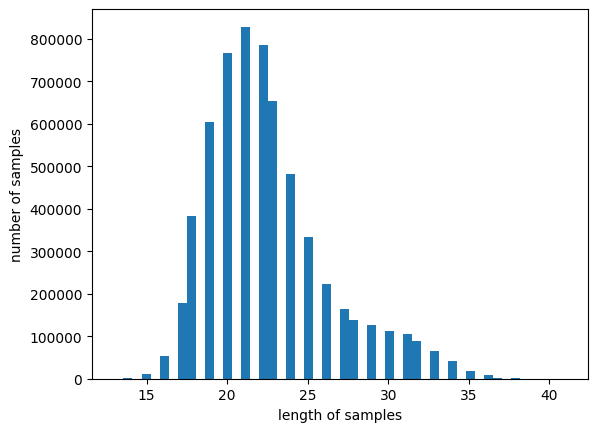

In [10]:
print('민원글 최대 길이 :',max(len(l) for l in tokenized_data))
print('민원글 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### word2vec 훈련

In [17]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=tokenized_data,  # 토크나이즈된 데이터
    vector_size=150,           # 단어 벡터 크기: 중간 수준
    window=5,                  # 주변 단어 범위
    min_count=1,               # 최소 등장 빈도
    workers=4,                 # CPU 코어 수
    sg=1                       # CBOW 사용
)


In [19]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (805, 150)


In [20]:
print(model.wv.most_similar("음식물"))

[('하수구', 0.7345585823059082), ('부패', 0.6240465641021729), ('청소', 0.5641739368438721), ('찬', 0.549929678440094), ('기름진', 0.535098671913147), ('암모니아', 0.5332540273666382), ('습기', 0.523317813873291), ('폐수', 0.5086541175842285), ('소독약', 0.5078650116920471), ('옷', 0.48050370812416077)]


In [21]:
print(model.wv.most_similar("쓰레기"))

[('하수구', 0.6850461959838867), ('부패', 0.5588443875312805), ('쓰레기통', 0.46538788080215454), ('통로', 0.4410783648490906), ('침실', 0.4372892677783966), ('거실', 0.43110230565071106), ('축축', 0.4308193027973175), ('폐수', 0.42211514711380005), ('곰팡이', 0.4180712103843689), ('소독약', 0.4119892120361328)]


In [22]:
print(model.wv.most_similar("냄새"))

[('찌르', 0.6830598711967468), ('혼합', 0.6810232400894165), ('불쾌', 0.6610103249549866), ('매캐', 0.6448310017585754), ('발생', 0.6440247893333435), ('침투', 0.6079787611961365), ('.', 0.5973659157752991), ('성', 0.590620756149292), ('폐기물', 0.5899481177330017), ('고', 0.5831723213195801)]


### 모델 저장 및 로드

In [23]:
from gensim.models import KeyedVectors

model.wv.save_word2vec_format('./kor_w2v') # 모델 저장

# loaded_model = KeyedVectors.load_word2vec_format("./kor_w2v") # 모델 로드